#### Please be sure to import the modules in the requirements.txt file

In [ ]:
!pip install -r functions/requirements.txt

In [1]:
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import math
import pickle

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

from sklearn.model_selection import train_test_split

from monai.networks.nets import SwinUNETR
import pydicom



torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.


#### Auxiliary functions useful for the segmentation pipeline

In [2]:
functions_dir = os.path.join(os.getcwd(), 'functions')

if functions_dir not in sys.path:
    sys.path.append(functions_dir)

    
from loss import *
from utils import *
from image_preprocessing import *
from evaluation import *
from visualization_3d import *
from training import *
from calculate_geometry import *

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



### Importing the data

In [3]:
curr_path=os.getcwd()

images_dir=curr_path+"\\arXiv\\images\\images"
masks_dir=curr_path+"\\arXiv\\masks\\masks"

#List files in the directory
file_list_img = os.listdir(images_dir)
file_list_msk = os.listdir(masks_dir)

#Sort the files using the extracted number as the key
sorted_files_img = sorted(file_list_img, key=extract_number)
sorted_files_msk = sorted(file_list_msk, key=extract_number)

sorted_files_img_we= [filename.removesuffix(".mha") for filename in sorted_files_img]
sorted_files_msk_we = [filename.removesuffix(".mha") for filename in sorted_files_msk]

#### Loading imaging and masks of lumbar intervertebral discs (t2 weighted MRIs)
#### Please be aware that this pipeline can be easily adjusted to work with t1 weighted MRIs and with lumbar vertebrae/spinal cord instead of intervertebral disc

In [4]:
target_resolution = (1.4, 1.2, 1.5) 

img_t2 = []

msk_t2_vert = []
msk_t2_disk = []
msk_t2_spinal = []



for i, (img_file, img_file_we) in enumerate(zip(sorted_files_img, sorted_files_img_we)):
    img_path = os.path.join(images_dir, img_file)
    
    #Images are resampled to the target resolution
    np_image = process_image(img_path, target_resolution)
    
    if np_image is None:
        continue

    msk_path = os.path.join(masks_dir, img_file)
    
    #Masks are resampled to the target resolution
    masks = process_mask(msk_path, np_image.shape)


    if "t2" in img_path:
         img_t2.append(np_image)
         #msk_t2_vert.append(masks["vert"])
         msk_t2_disk.append(masks["disk"])
         #msk_t2_spinal.append(masks["spinal"])


### Data preprocessing
#### These steps are carried out since the DL model used (swin transformer from MONAI) expects images whose shape is multiple of 32

In [5]:
#Crop all images and masks
cropped_img_t2, cropped_msk_t2=crop_images_masks(img_t2, msk_t2_disk)

#Find the maximum dimensions across all cropped images and masks
max_dim1_t2, max_dim2_t2, max_dim3_t2=find_max_dimensions(cropped_msk_t2)
target_dims_t2=(next_multiple_of_32(max_dim1_t2), next_multiple_of_32(max_dim2_t2), next_multiple_of_32(max_dim3_t2))

#Pad all cropped images and masks to the target dimensions
img_t2_fin, msk_t2_fin=pad_images_masks(cropped_img_t2, cropped_msk_t2, target_dims_t2, pad_value_img=-1000, pad_value_msk=0)

#Stack the final lists to create 3D numpy arrays
img_t2_np=np.stack(img_t2_fin)
msk_t2_np=np.stack(msk_t2_fin)

#Processing the images (voxel values rescaled from 0 to 1)
img_t2_proc=np.expand_dims(process_image_4d(img_t2_np, mask=0), axis=1)
msk_t2_proc=np.expand_dims(msk_t2_np, axis=1)

#### Example of a t2-weighted lumbar spine MRI from the dataset

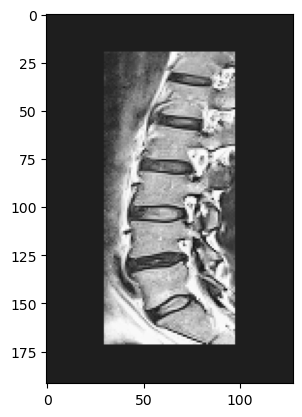

In [6]:
plt.imshow(np.flipud(img_t2_proc[10,0,:,:,60]), cmap="gray")

#### Example of a t2-weighted lumbar spine MRI from the dataset and its correspondent ground truth mask

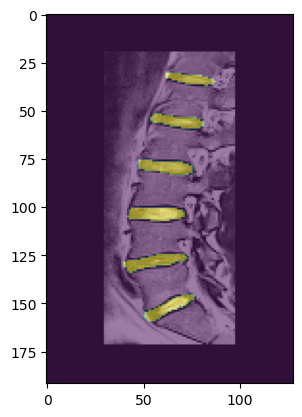

In [7]:
plt.imshow(np.flipud(msk_t2_proc[10,0,:,:,60]))
plt.imshow(np.flipud(img_t2_proc[10,0,:,:,60]), cmap="gray", alpha=0.5)

### Dataset splitting

In [9]:
batch_size=4

train_data_3d, temp_data_3d, train_labels_3d, temp_labels_3d=train_test_split(img_t2_proc, msk_t2_proc, test_size=0.4, random_state=15)
val_data_3d, test_data_3d, val_labels_3d, test_labels_3d = train_test_split(temp_data_3d, temp_labels_3d, test_size=0.5, random_state=15)


dataset_training_3d=torch.utils.data.TensorDataset(torch.tensor(train_labels_3d), torch.tensor(train_data_3d))
training_loader_3d=torch.utils.data.DataLoader(dataset_training_3d, batch_size=batch_size, shuffle=False)

dataset_validation_3d=torch.utils.data.TensorDataset(torch.tensor(val_labels_3d), torch.tensor(val_data_3d))
validation_loader_3d=torch.utils.data.DataLoader(dataset_validation_3d, batch_size=batch_size, shuffle=False)

dataset_testing_3d=torch.utils.data.TensorDataset(torch.tensor(test_labels_3d), torch.tensor(test_data_3d))
testing_loader_3d=torch.utils.data.DataLoader(dataset_testing_3d, batch_size=batch_size, shuffle=False)

### Importing the 3d Model and Training

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinUNETR(
    img_size=(96, 192, 128),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=True,
).to(device)



In [43]:
best_iou = 0.0

train_losses = []
val_losses = []
train_ious = []
train_dices = []
val_ious = []
val_dices = []


learning_rate=0.001
num_epochs=50
epochs_image=5


model=model.to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training loop
for epoch in range(num_epochs):
    train_running_loss=0.0
    train_iou=0.0
    train_dice=0.0

    model=model.train()

    
    for i, (labels, images) in enumerate(training_loader_3d):
        
        images=images.float().to(device)
        labels=labels.float().to(device)
        
        logits=model(images)
        logits=torch.sigmoid(logits)
        
        loss=combined_dice_bce_loss(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()


        optimizer.step()

        train_running_loss+=loss.detach().item()
        train_iou+=get_iou_train(logits, labels)
        train_dice+=get_dice(logits, labels)




    # Validation
    model.eval()
    val_running_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for j, (labels, images) in enumerate(validation_loader_3d):
            images = images.float().to(device)
            labels = labels.float().to(device)
            logits = model(images)
            logits = torch.sigmoid(logits)
            
            val_loss = combined_dice_bce_loss(logits, labels)  
            val_running_loss += val_loss.item()
            
            val_iou += get_iou_train(logits, labels)
            val_dice += get_dice(logits, labels)




    train_losses.append(train_running_loss/len(training_loader_3d))
    train_ious.append(train_iou/len(training_loader_3d))
    train_dices.append(train_dice/len(training_loader_3d))
    val_losses.append(val_running_loss/len(validation_loader_3d))
    val_ious.append(val_iou/len(validation_loader_3d))
    val_dices.append(val_dice/len(validation_loader_3d))



    print('Epoch: %d | Loss: %.4f | Train iou (mean): %.2f | Train dice (mean): %.2f | Val loss: %.4f | Val iou (mean): %.2f | Val dice (mean): %.2f'
          % (epoch, train_running_loss / len(training_loader_3d), train_iou / len(training_loader_3d), train_dice / len(training_loader_3d),
             val_running_loss / len(validation_loader_3d), val_iou / len(validation_loader_3d), val_dice / len(validation_loader_3d)))

    # Saving the best model based on validation IOU
    if val_iou/len(validation_loader_3d) > best_iou:
        best_iou = val_iou/len(validation_loader_3d)
        torch.save(model.state_dict(), 'best_model_weights_lumbar_disc_github.pth')






Epoch: 0 | Loss: 0.8531 | Train iou (mean): 0.37 | Train dice (mean): 0.26 | Val loss: 0.8366 | Val iou (mean): 0.63 | Val dice (mean): 0.43
Epoch: 1 | Loss: 0.8339 | Train iou (mean): 0.63 | Train dice (mean): 0.54 | Val loss: 0.8324 | Val iou (mean): 0.69 | Val dice (mean): 0.62
Epoch: 2 | Loss: 0.8314 | Train iou (mean): 0.69 | Train dice (mean): 0.67 | Val loss: 0.8310 | Val iou (mean): 0.74 | Val dice (mean): 0.72
Epoch: 3 | Loss: 0.8305 | Train iou (mean): 0.72 | Train dice (mean): 0.74 | Val loss: 0.8305 | Val iou (mean): 0.76 | Val dice (mean): 0.77
Epoch: 4 | Loss: 0.8300 | Train iou (mean): 0.74 | Train dice (mean): 0.78 | Val loss: 0.8301 | Val iou (mean): 0.77 | Val dice (mean): 0.81
Epoch: 5 | Loss: 0.8297 | Train iou (mean): 0.75 | Train dice (mean): 0.81 | Val loss: 0.8299 | Val iou (mean): 0.77 | Val dice (mean): 0.83
Epoch: 6 | Loss: 0.8296 | Train iou (mean): 0.75 | Train dice (mean): 0.82 | Val loss: 0.8299 | Val iou (mean): 0.77 | Val dice (mean): 0.84
Epoch: 7 | Lo

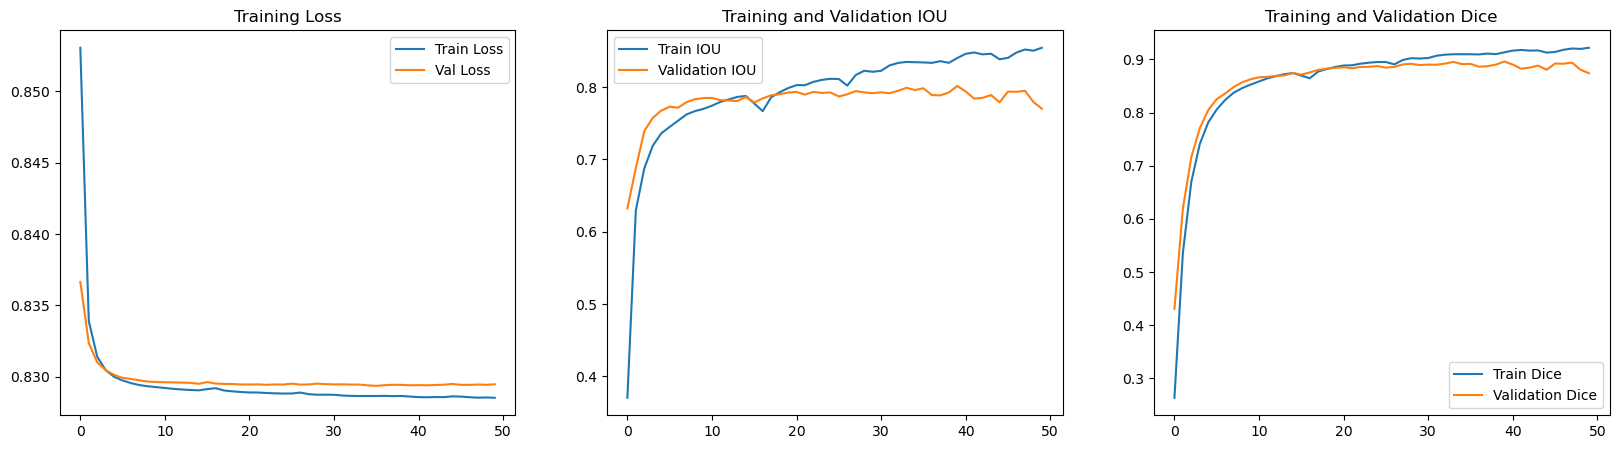

In [44]:
plot_training_metrics(num_epochs, train_losses, val_losses, train_ious, train_dices, val_ious, val_dices)

In [45]:
#Loading the saved weights
path_weights="C:\\Users\\Mattia\\Desktop\\Datasets\\Datasets\\Dataset_MRI_van_der_graaf\\van_der_graaf\\best_model_weights_lumbar_disc_github.pth"



#save_model_weights(model, path_weights)
load_model_weights(model, path_weights)

print("Training set metrics: ")
train_output, iou_list_train, dice_list_train = inference(training_loader_3d, model, batch_size, train_data_3d)

print("Test set metrics: ")
test_output, iou_list_test, dice_list_test = inference(testing_loader_3d, model, batch_size, test_data_3d)


ci_low, ci_high = calculate_ci(iou_list_test)
print(f"95% confidence interval iou - test set: ({round(ci_low,2)}, {round(ci_high,2)})")

ci_low, ci_high = calculate_ci(dice_list_test)
print(f"95% confidence interval dice - test set: ({round(ci_low,2)}, {round(ci_high,2)})")


Training set metrics: 
mean_iou: 0.8478173498854302, mean_dice: 0.9173125036951093
Test set metrics: 
mean_iou: 0.7852503057616201, mean_dice: 0.8789379921016682
95% confidence interval iou - test set: (0.77, 0.8)
95% confidence interval dice - test set: (0.87, 0.89)


#### Example of a t2-weighted lumbar spine MRI from the dataset and its correspondent predicted mask

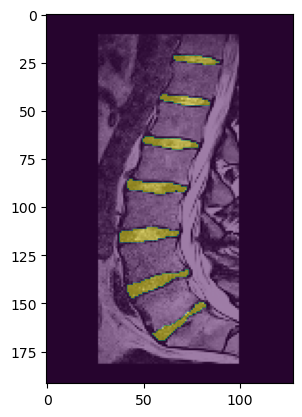

In [13]:
plt.imshow(np.flipud(np.squeeze(np.stack(test_output))[20,:,:,48]))
plt.imshow(np.flipud(np.squeeze(test_data_3d)[20,:,:,48]), cmap="gray", alpha=0.5)